In [1]:
%pylab inline
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
import numpy as np

Populating the interactive namespace from numpy and matplotlib


Download the data:

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Look at a few images

In [3]:
print("X values", mnist.train.images.shape)
print("Y values", mnist.train.labels.shape)

X values (55000, 784)
Y values (55000, 10)


[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


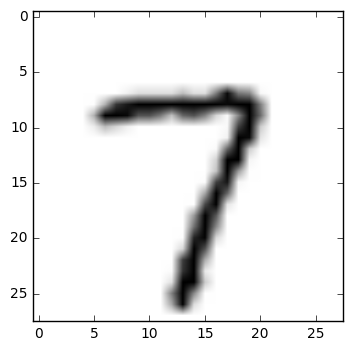

In [4]:
ind = 100
imshow(np.reshape(mnist.train.images[ind], (28,28)), cmap='Greys')
print(mnist.train.labels[ind])

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


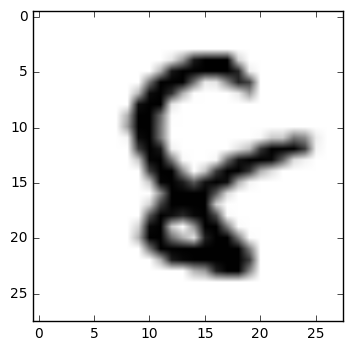

In [5]:
ind = 800
imshow(np.reshape(mnist.train.images[ind], (28,28)), cmap='Greys')
print(mnist.train.labels[ind])

![Xs](https://www.tensorflow.org/versions/r0.11/images/mnist-train-xs.png)
![Ys](https://www.tensorflow.org/versions/r0.11/images/mnist-train-ys.png)

# Define the model

Define input Place holders:

In [6]:
with tf.name_scope("input_layer"):
    x = tf.placeholder(tf.float32, [None, 784], name="inputX")
    py = tf.placeholder(tf.float32, [None, 10])

A few helper functions to make small random starting weights

In [7]:
def weight_variable(shape, name):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = name)

Define the two hidden layer model:

$$
y = \textbf{SoftMax}\left(
W_2
\cdot
\textbf{ReLU}\left(W_1 \cdot
\textbf{ReLU}\left(W_0 \cdot x
+ b_0
\right)
+ b_1
\right)
+ b_2
\right)
$$

In [8]:
nhidden1 = 128
nhidden2 = 32

with tf.name_scope("model"):
    with tf.name_scope("hidden_layer_1"):
        W0 = weight_variable([784, nhidden1], "w0")
        b0 = bias_variable([nhidden1], "b0")
        hidden1 = tf.nn.relu(tf.matmul(x, W0) + b0, name="hidden1")

    with tf.name_scope("hidden_layer_2"):
        W1 = weight_variable([nhidden1, nhidden2], 'w1')
        b1 = bias_variable([nhidden2], 'b1')
        hidden2 = tf.nn.relu(tf.matmul(hidden1, W1) + b1, name="hidden2")

    with tf.name_scope("softmax_layer"):
        W2 = weight_variable([nhidden2, 10], 'w2')
        b2 = bias_variable([10], 'b2')
        pyhat = tf.nn.softmax(tf.matmul(hidden2, W2) + b2)

## Define the loss Function

Here we use the standard *Cross Entropy*:

$$
H(p_y, p_\hat{y}) = - \sum_j p_y(j) \log p_\hat{y}(j)
$$

Notice that since $p_y(j) = 1$ when $j$ is the true digit and $p_y(j') = 0$ otherwise.  Therefore:

$$
H(p_y, p_\hat{y}) = -\log p_\hat{y}(\text{true label})
$$



In [9]:
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(pyhat, py)
    with tf.name_scope('total'):
        avg_cross_entropy = tf.reduce_mean(cross_entropy)
    tf.scalar_summary('cross entropy', avg_cross_entropy)

## Define the prediction error (monitoring)

In [10]:
with tf.name_scope('error'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(pyhat, 1), tf.argmax(py, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.scalar_summary('accuracy', accuracy)

## Define one step of the optimization algorithm

In [11]:
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.01).minimize(avg_cross_entropy)

## Compile Graph and Initialize Variables

In [12]:
init = tf.initialize_all_variables()
# sess = tf.InteractiveSession()
sess = tf.Session()
sess.run(init)

Clear previous Logs

In [13]:
if tf.gfile.Exists('logs'):
    tf.gfile.DeleteRecursively('logs')
tf.gfile.MakeDirs('logs')

Create a Helper function to define training and test data samples

In [14]:
def bind_data(data_type):
    batch_size = 100
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if data_type == 'train':
        xs, ys = mnist.train.next_batch(batch_size)
    else:
        xs, ys = mnist.test.images, mnist.test.labels
    return {x: xs, py: ys}

Save a few training images for visualization:

In [15]:
# Collect a few training images
input_writer= tf.train.SummaryWriter('logs/input', sess.graph)
training_img_summary = tf.image_summary('training_images', 
                                        tf.reshape(x, [-1, 28, 28, 1]), 20)
summary = sess.run(training_img_summary, feed_dict=bind_data('train'))
input_writer.add_summary(summary)
input_writer.close()

In [16]:
# Runt he actual algorithm
train_writer = tf.train.SummaryWriter('logs/train', sess.graph)
test_writer = tf.train.SummaryWriter('logs/test')

merged = tf.merge_all_summaries()

for i in range(2000):
    if i % 10 == 1:
        summary, acc = sess.run([merged, accuracy], feed_dict=bind_data('test'))
        test_writer.add_summary(summary, i)
        print('Accuracy at step %s: %s' % (i, acc))
    if i % 200 == 10:  # Record execution stats
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        summary, _ = sess.run([merged, train_step],
                              feed_dict=bind_data('train'),
                              options=run_options,
                              run_metadata=run_metadata)
        train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
        train_writer.add_summary(summary, i)
        print('Adding run metadata for', i)
    else:
        # Record a summary
        summary, _ = sess.run([merged, train_step], feed_dict=bind_data('train'))
        train_writer.add_summary(summary, i)

train_writer.close()
test_writer.close()

Accuracy at step 1: 0.1795
Adding run metadata for 10
Accuracy at step 11: 0.6068
Accuracy at step 21: 0.7194
Accuracy at step 31: 0.7517
Accuracy at step 41: 0.7884
Accuracy at step 51: 0.8099
Accuracy at step 61: 0.8053
Accuracy at step 71: 0.7905
Accuracy at step 81: 0.8082
Accuracy at step 91: 0.8198
Accuracy at step 101: 0.8215
Accuracy at step 111: 0.8765
Accuracy at step 121: 0.8797
Accuracy at step 131: 0.8751
Accuracy at step 141: 0.9059
Accuracy at step 151: 0.873
Accuracy at step 161: 0.8866
Accuracy at step 171: 0.8941
Accuracy at step 181: 0.8839
Accuracy at step 191: 0.9038
Accuracy at step 201: 0.8976
Adding run metadata for 210
Accuracy at step 211: 0.893
Accuracy at step 221: 0.9072
Accuracy at step 231: 0.8919
Accuracy at step 241: 0.9102
Accuracy at step 251: 0.923
Accuracy at step 261: 0.8884
Accuracy at step 271: 0.9137
Accuracy at step 281: 0.9149
Accuracy at step 291: 0.9121
Accuracy at step 301: 0.9221
Accuracy at step 311: 0.9249
Accuracy at step 321: 0.9085
Ac